In [1]:
import cv2
import glob
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy import ndimage
from utils import pre_process


%matplotlib inline

Using TensorFlow backend.


In [2]:
SIMULATOR_HOME = "/Users/ddigges/simulator/data/"
DRIVING_LOG_FILE = "driving_log.csv"
DRIVING_LOG_FILE_PATH = os.path.join(SIMULATOR_HOME, DRIVING_LOG_FILE)

IMG = "IMG"
IMAGE_PATH = os.path.join(SIMULATOR_HOME, IMG)

#steering_offset = 0.28
steering_offset = 0.25
num_channels = 3

In [3]:
driving_log = pd.read_csv(DRIVING_LOG_FILE_PATH)

In [4]:
driving_log.columns = ["center", "left", "right", "steering", "throttle", "brake", "speed"]

In [5]:
driving_log.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [6]:
def invert(df, drop_zeros=True):
    """
        1. Create a copy of the data frame
        2. Reverse each angle by multiplying by -1
        3. Append "INV" to image path
    """
    inv_df = df.copy()
    
    if(drop_zeros):
        inv_df = inv_df[inv_df.angle != 0]
    
    inv_df.angle *= -1
    inv_df.image += "INV"
    return inv_df

In [7]:
def get_copy(df, column, angle_offset=0):
    res = df[[column, "steering"]]
    res.columns = ["image", "angle"]
    res.angle += angle_offset
    return res

In [8]:
# Center image, angle unchanged
center = get_copy(driving_log, "center")

# Center image, filter zero angles
# invert angle, flip image
center_inverted = invert(center)

# Add random value to each pixel
center_add_randn = get_copy(driving_log, "center")
center_add_randn = center_add_randn[center_add_randn.angle != 0]
center_add_randn.image += "ADD"

# Multiply random value to each image pixel
center_mul_randn = get_copy(driving_log, "center")
center_mul_randn = center_mul_randn[center_mul_randn.angle != 0]
center_mul_randn.image += "MUL"

# Gaussian blur
center_blur = get_copy(driving_log, "center")
center_blur = center_blur[center_blur.angle != 0]
center_blur.image += "BLUR"

# Left image, Add steering offset
left = get_copy(driving_log, "left", steering_offset)

# Left image, Invert steering offset, flip image
#left_inv = invert(left)

# Right image, subtract steering offset
right = get_copy(driving_log, "right", -steering_offset)

# Right image, invert steering offset, flip image
#right_inv = invert(right)



all_data = pd.concat([center, center_inverted, left, right , center_add_randn, center_mul_randn, center_blur])#, left_inv, right_inv])



/Users/ddigges/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [9]:
n = all_data.shape[0]
batch_size = 128
samples_per_epoch = int(n/batch_size)
nb_epoch = 10

In [10]:
image = mpimg.imread(os.path.join(SIMULATOR_HOME, driving_log[:1]['center'][0]))
conv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

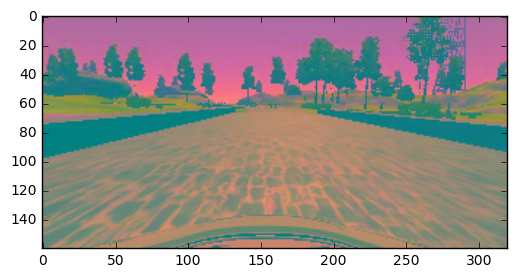

In [11]:
plt.imshow(conv_image)

In [12]:
rows_to_crop_top = int(image.shape[0] * 0.3)
rows_to_crop_bottom = int(image.shape[0] * 0.1)

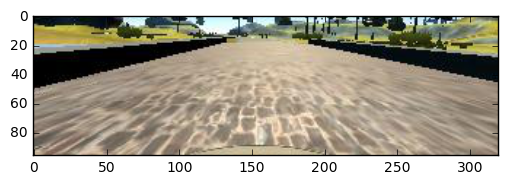

In [13]:
image = image[rows_to_crop_top:image.shape[0] - rows_to_crop_bottom, :, :]
plt.imshow(image)

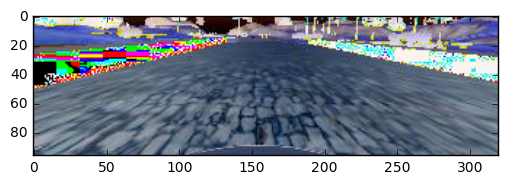

In [14]:
row,col,ch= image.shape
mean = 0
sigma = 0.0000001
gauss = np.random.normal(mean,sigma,(row,col,ch))
noisy = image + gauss
plt.imshow(noisy)

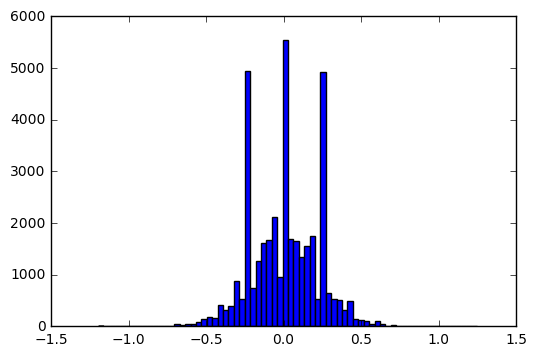

In [15]:
plt.hist(all_data.angle, bins=70);

In [16]:
def read_image(file_name):
    return plt.imread(file_name)

In [17]:
val = driving_log[:1]['center']

In [18]:
image = read_image(os.path.join(SIMULATOR_HOME, val.values[0]))

In [19]:
# IMAGE: 160 x 320 with 3 color channels
image.shape

(160, 320, 3)

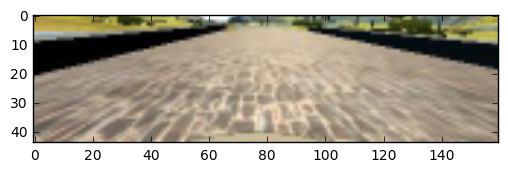

In [20]:
image = plt.imread(os.path.join(SIMULATOR_HOME, driving_log[:1]['center'][0]))
image = pre_process(image, num_channels)
plt.imshow(image)

In [21]:
for i, row in driving_log[:3].iterrows():
    print(row['center'], row['steering'])

IMG/center_2016_12_01_13_30_48_287.jpg 0.0
IMG/center_2016_12_01_13_30_48_404.jpg 0.0
IMG/center_2016_12_01_13_31_12_937.jpg 0.0


In [22]:
# shuffle
driving_log = driving_log.sample(frac=1).reset_index(drop=True)

In [23]:
driving_log.shape

(8036, 7)

In [24]:
def get_flipped_image(image_name):
    image_name = image_name.replace("INV", "")
    image = mpimg.imread(os.path.join(SIMULATOR_HOME, image_name))
    image = cv2.flip(image,1)
    return image

In [25]:

def add_random_value_to_image(image_name, op):
    image_name = image_name.replace(op, "")
    image = mpimg.imread(os.path.join(SIMULATOR_HOME, image_name))
    

    if(op == "ADD"):
        randn = np.array(random.randint(-5, 5), dtype=np.uint8)
        image += randn
        
    elif(op == "MUL"):
        randn = np.array(random.randint(1, 3), dtype=np.uint8)
        image *= randn
        
    np.clip(image, 0, 255, out=image)
    return image

In [26]:
def get_blurred_image(image_name):
    image_name = image_name.replace("BLUR", "")
    image = mpimg.imread(os.path.join(SIMULATOR_HOME, image_name))
    
    return ndimage.gaussian_filter(image, sigma=1)

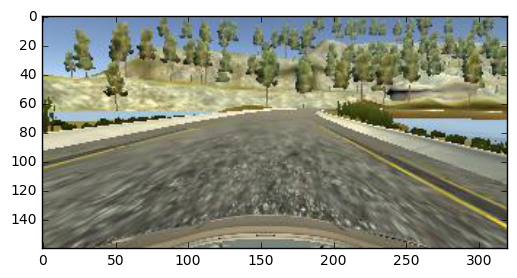

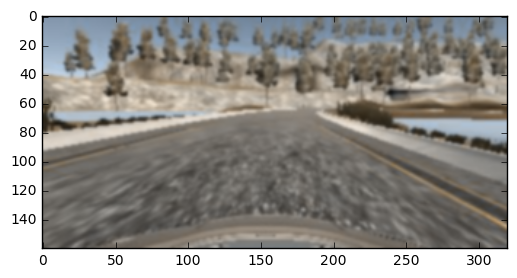

False

In [27]:
image = all_data[200:201]['image'][200] + "BLUR"

plt.imshow(plt.imread(os.path.join(SIMULATOR_HOME, all_data[200:201]['image'][200].strip())))
plt.show()
conv_image = get_blurred_image(image)
conv_image.shape
plt.imshow(conv_image)
plt.show()
np.all(plt.imread(os.path.join(SIMULATOR_HOME, all_data[200:201]['image'][200].strip()))[:10,:,] == conv_image[:10,:,])

In [28]:
def get_image(row):
    image_name = row["image"].strip()
    
    if image_name.endswith("INV"):
        return get_flipped_image(image_name)
    
    elif image_name.endswith("ADD"):
        return add_random_value_to_image(image_name, "ADD")
    
    elif image_name.endswith("MUL"):
        return add_random_value_to_image(image_name, "MUL")
    
    elif image_name.endswith("BLUR"):
        return get_blurred_image(image_name)
    else:
        image = mpimg.imread(os.path.join(SIMULATOR_HOME, image_name))
    return image

In [29]:
def data_generator(df, batch_size=128):
    n_rows = df.shape[0]
    while True:
        # Shuffle the data frame rpws after every complete cycle through the data
        df = df.sample(frac=1).reset_index(drop=True)
        
        for index in range(0, n_rows, batch_size):
            df_batch = df[index: index + batch_size]

            # Ignoring the last batch which is smaller than the requested batch size
            if(df_batch.shape[0] == batch_size):
                X_batch = np.array([pre_process(get_image(row)) for i, row in df_batch.iterrows()])
                y_batch = np.array([row['angle'] for i, row in df_batch.iterrows()])
                yield X_batch, y_batch


In [30]:
gen = data_generator(all_data)

In [31]:
X_batch, y_batch = next(gen)

In [32]:
X_batch.shape

(128, 44, 160, 3)

In [33]:
y_batch.shape

(128,)

(array([  2.,   2.,   3.,  25.,  18.,  36.,  12.,  22.,   6.,   2.]),
 array([-0.6990258 , -0.57785331, -0.45668082, -0.33550833, -0.21433584,
        -0.09316335,  0.02800914,  0.14918163,  0.27035412,  0.39152661,
         0.5126991 ]),
 <a list of 10 Patch objects>)

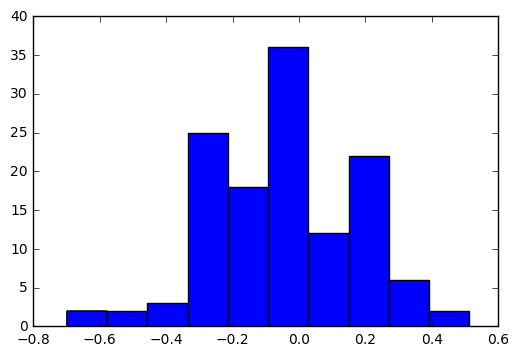

In [34]:
plt.hist(y_batch)

In [35]:
gen = data_generator(all_data)

x,y = next(gen)
x.shape
gen = data_generator(all_data)
print(x.shape)
print(num_channels
     )

(128, 44, 160, 3)
3


In [36]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(x.shape[1], x.shape[2], x.shape[3]),
            output_shape=(x.shape[1], x.shape[2], x.shape[3])))
model.add(Convolution2D(3, 1, 1, subsample=(4, 4), border_mode="same"))
model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.2))
model.add(ELU())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))

In [37]:
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss="mse")

In [38]:
model.fit_generator(gen, samples_per_epoch*batch_size, nb_epoch=2)

Epoch 1/2
38784/38784 [==============================] - 192s - loss: 0.0465   
Epoch 2/2
38784/38784 [==============================] - 190s - loss: 0.0371   


In [39]:
model.save_weights("model.h5")

In [40]:
file = open("model.json", "w")
file.write(model.to_json())
file.close()